In [1]:
#Import Liabraries
import pandas as pd
from collections import defaultdict, Counter
import os
from itertools import chain
import sklearn.preprocessing as skp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import conll_utils
import time
from preprocessing_utils import SequenceEncoder
import matplotlib.pyplot as plt
import numpy as np
import matplotlit_utils

In [2]:
%%time
dataset = conll_utils.from_dir('C:/Users/Mazz Issa/Documents/Kurse/TA/Project/dataset_courts')

Wall time: 20.1 s


#### add  column ' sentences ' to the data frame

In [3]:
pred = dataset['predictors']
sentences = []
for sen in range(len(pred)):
    sentences.append("sentence {}".format(sen+1))
sentences
dataset.insert(0, "Sentences", sentences, True) 

In [4]:
df= dataset
df.head(2)

,Sentences,predictors,labels,file
0,sentence 1,"[Prozesskostenhilfe, -, Entschädigung, für, üb...","[O, O, O, O, O, O, O, O]",bag
1,sentence 2,"[Der, Antrag, auf, Gewährung, von, Prozesskost...","[O, O, O, O, O, O, O, O, O, O, O, B-AN, O, O, ...",bag


### Data preparation 

In [5]:
predictors, labels = df['predictors'], df['labels']

###### SequenceEncoder 
mimics the keras's Tokenizer utilities.

In [6]:
predictor_encoder = SequenceEncoder(max_sequence_len = 100)

In [7]:
predictor_encoder.fit(predictors)

###### assign a unique number to each unique word in predictors and extends/cuts each sentence in predictors to length of 100

In [8]:
print("Predictors before sequencing:\n {}". format(predictors[:1]))
encoded_words = predictor_encoder.transform(predictors) 
print("\nEncoded predictors:\n {}".format(encoded_words[:1]))

Predictors before sequencing:
 0    [Prozesskostenhilfe, -, Entschädigung, für, üb...
Name: predictors, dtype: object

Encoded predictors:
 0    [2740, 11, 2817, 18, 11822, 3894, 11, 792, 0, ...
Name: predictors, dtype: object


In [9]:
## 2D array of all rows in df['predictors'] , shape (66723, 100) 
words = np.array(encoded_words.tolist())  

## sorted list of all unique encoded words(their assigned numbers)
unique_words = np.unique(words)

## value of the largest encoded word
words_dim = unique_words[-1] 

###### assign a unique number to each label in labels

In [10]:
label_encoder = SequenceEncoder(max_sequence_len = 100, special_tokens = ['<EMPTY>'])
label_encoder.fit(labels)
print("labels before sequencing:\n{}". format(labels[:1]))
encoded_labels = label_encoder.transform(labels)
print("\nEncoded labels:\n{}".format(encoded_labels[:1]))

labels before sequencing:
0    [O, O, O, O, O, O, O, O]
Name: labels, dtype: object

Encoded labels:
0    [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: labels, dtype: object


In [11]:
labels_array = np.array(encoded_labels.tolist()) ## 2D array of all rows in df['labels'] , shape : 66723,100
labels_num = len(np.unique(labels_array))
print("Number of Labels: ",labels_num)

Number of Labels:  40


###### to_categorical:
represent each one of the labels in a unique binary vector

In [12]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i,num_classes=40) for i in labels_array]  ## we have 39 classes and the 0
y[:1]

[array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

###### binary_to_label: (reverses 'to_categorical'  function)
Reverse the binary representation of labels to their encoded form

In [13]:
def binary_to_label(binary_labels):
    reverse_ = []
    for y in binary_labels:
        reverse_.append(np.argmax(y, axis=-1))
    return reverse_

### Cross Validation 

In [14]:
## first we divide the dataset into k-folds
import sklearn
def shuffle_data(Data, Target):
    return sklearn.utils.shuffle(Data, Target)

def cross_validation(Data, Target, L):
    
    split_combination = []
    historia = []
    historia_split_num = []
    ## shuffle data and target in the same order.
    ##example data[[1,2],[4,5],[7,8]], target [10,11,12] => after shuffle ==> data[[4,5],[7,8],[1,2]], target [11,12,10]
    data_, target_ = shuffle_data(Data, Target)
    
    ## Note i have to save the order of the shuffled data and return it too 
    
    ## split data and target into L slices
    
    split_data = np.asarray(np.array_split(data_,L, axis = 0))
    split_target = np.array(np.array_split(target_, L))
    ## list to store errors rate of each slice prediction 
    errors = []
    ##for L slices take one slice as test and the rest as training
    for i in range(L):
        print("\nSlice Nr: {}\n".format(i+1))
        # test_data and test_target for a certain slice in L
        data_test = split_data[i]
        target_test = split_target[i]
        data_train = np.concatenate([split_data[j] for j in range(L) if j != i])
        target_train = np.concatenate([split_target[j] for j in range(L) if j != i])
        
        split_combination.append(([data_train, target_train] ,[data_test, target_test]))
        ## divide the training data, target to 20% validation data/target ##  or maybe not!
        historia.append(model_call(data_train, target_train, exec(f'LSTM_model_{i+1} = None')))
            
            #errors.append(prediction_error_rate)
            
    #error_rate_mean = np.mean(errors)
    #error_rate_StandardDiviation = np.std(errors)
    #print("Error rate mean is: {}%,  Error rate standard deviation is: {}%".format(error_rate_mean,error_rate_StandardDiviation))
    return split_combination, historia ### so we can use the same split  #error_rate_mean,error_rate_StandardDiviation,

In [21]:
def get_best_model(Data, Target, L): ## function calls train data on a model using cross validation
    
    Schuffled_target, cross_historia = cross_validation(Data, Target, L)  ## cross validation and train one model
    history_list = []
    ## this loops stores each of loss,accuracy, value_loss, value_accuracy in a list
    for i in cross_historia:
        history_list.append([val for v in i[0].history.values() for val in v]) 
    arr = np.vstack([val for val in history_list])
    loss_less = np.argmin((arr[:,[0,2]]),axis=0) ## these columns contain the loss and val loss 
    val_high = np.argmax((arr[:,[1,3]]),axis=0) ## these columns contain the accuracy and value accuracy
    loss_acc = np.concatenate((loss_less, val_high))
    most_frequent = np.argmax(np.bincount(loss_acc)) ## most frquent vector (vectors with the best results)
    best_ =  loss_acc[most_frequent]
    
    return cross_historia[best_] , Schuffled_target[best_] ## returns the best split, history and the model that was used

### Training LSTM model

In [22]:
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense , Embedding ,LSTM
from keras import Model, Input
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
import keras

In [23]:
def model_call(x_train, y_train, model):
    max_len = 100
    input_word = Input(shape =(max_len, ))
    model = Embedding(input_dim = words_dim+1, output_dim = max_len, input_length = max_len)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(40, activation='softmax'))(model)
    model = Model(input_word, out)
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model.fit(x_train, y_train, epochs=5, validation_split=0.2) , model

###### Split data into training and testing 
for the encoded_words will represent X_data, y (binary form of the labels) will represent Y_data

In [24]:
Data , Target = np.array(encoded_words.tolist()) , np.array(y)
Data.shape, Target.shape

((66723, 100), (66723, 100, 40))

In [32]:
best_model ,best_split = get_best_model(Data, Target,5)

C:\Users\Mazz Issa\anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Slice Nr: 1

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          8158300   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 40)           8040      
Total params: 8,327,140
Trainable params: 8,327,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1335/1335 [==============================] - 707s 518ms/step - loss: 0.3668 - accuracy: 0.9

In [33]:
history, model = best_model[0], best_model[1]
train_data, test_data = (best_split[0], best_split[1])
#ithinkso = test_to_df(test_data[0], model)
print(history, model)

<tensorflow.python.keras.callbacks.History object at 0x0000025DDBFB4F48> <tensorflow.python.keras.engine.functional.Functional object at 0x0000025E00F5F3C8>


In [39]:
model.summary() ## the model that was choosen 

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 100)          8158300   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 40)           8040      
Total params: 8,327,140
Trainable params: 8,327,140
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.save("LSTM_model")

INFO:tensorflow:Assets written to: LSTM_model\assets


### evaluation of the model

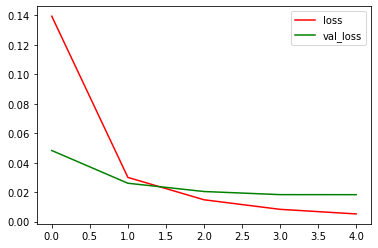

In [48]:
plt.plot(history.history['loss'], color='r', label='loss')
plt.plot(history.history['val_loss'], color='g', label = 'val_loss')
plt.legend()
plt.show()

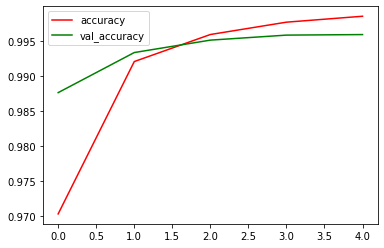

In [37]:
plt.plot(history.history['accuracy'], color='r', label='accuracy')
plt.plot(history.history['val_accuracy'], color='g', label = 'val_accuracy')
plt.legend()
plt.show()

### DataFrame of the prediction

In [40]:
def test_to_df(test_data, model):
    ## get the predicted labels 
    result = np.round(model.predict(test_data))  ## model.predicts returns values between 0 and 1, therefore, round the results
    ## change the predicted labels from binary to their encoded sequence and reverse the sequence to labels
    predicted_labels = label_encoder.reverse(binary_to_label(result)) 
    
    ## reverse the test_data sequence to words
    test_df = pd.Series(test_data.tolist()) 
    test_words = predictor_encoder.reverse(test_df)
    
    ## create a Dataframe
    return pd.DataFrame(zip(test_words,predicted_labels), columns=['predictors_test', 'labels_test'])

In [41]:
prediction_df = test_to_df(test_data[0],model)

In [42]:
result = model.evaluate(test_data[0], test_data[1], verbose=0)
print(f'Test loss: {result[0]} / Test accuracy: {result[1]}')

Test loss: 0.01907780021429062 / Test accuracy: 0.9956474900245667


In [47]:
prediction_df.sample(10)

,predictors_test,labels_test
9429,[Augat],[B-RR]
2406,"[In, die, nach, Art., 11, Abs., 2, Satz, 1, EM...","[O, O, O, B-EUN, I-EUN, I-EUN, I-EUN, I-EUN, I..."
6045,"[Das, Revisionsgericht, ist, in, einem, solche...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2463,"[(, 3, ), Schließlich, haben, die, Tarifvertra...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
10636,"[2., Die, Verfassungsbeschwerde, ist, im, Sinn...","[O, O, O, O, O, O, O, B-GS, I-GS, I-GS, I-GS, ..."
3802,"[Er, wurde, im, Zeitpunkt, der, Versetzung, au...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9198,"[Umgekehrt, ist, in, §, 1, Abs., 1, Satz, 2, K...","[O, O, O, B-VT, I-VT, I-VT, I-VT, I-VT, I-VO, ..."
11569,[Sost-Scheible],[B-RR]
3129,"[Nach, den, unangegriffenen, und, damit, ebenf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7264,"[Grundsätzlich, bedeutsam, im, Sinne, von, §, ...","[O, O, O, O, O, B-GS, I-GS, I-GS, I-GS, I-GS, ..."
